In [92]:
# Imports
import requests
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup as bs
import re
from stop_words import sw
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas
import numpy as np

## Define the url and the BeatifulSoup parser

In [93]:
URL = "https://en.wikipedia.org/wiki/Red_Hot_Chili_Peppers"

html = requests.get(URL).text
soup = bs(html, features="html.parser")

In [94]:
# Get div with id = content
divContent = soup.find("div",{"id":"content"})

In [95]:
text = divContent.get_text()
phrasesFromText = re.split("\n",text)
# separate all words separetly
wordsFromText = re.split(" |,|\n|\[|\]",text)
pattern = "\n|,|\. | "+" | ".join(sw)[0:-1]
corpusFromText = re.split(pattern,text)
wordsFromTextFiltered = list(filter(lambda word:
                                  isValidWord(word)
                                  ,wordsFromText))
corpusFromTextFiltered = list(filter(lambda word:
                                  isValidWord(word)
                                  ,corpusFromText))
corpusFromTextFilteredSplitted = []
for corpus in corpusFromTextFiltered:
    spplitedCorpus = corpus.split(" ")
    spplitedCorpus = list(filter(lambda word:
                                  isValidWord(word)
                                  ,spplitedCorpus))
    corpusFromTextFilteredSplitted.append(spplitedCorpus)

In [96]:
# Initialize vectorizer with one gram words
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
X = vectorizer.fit_transform(wordsFromTextFiltered)
featuresNames = vectorizer.get_feature_names()

## First approach will be find the words with most appearence

In [97]:
wordsAndAppearences = {}
for word in wordsFromTextFiltered:
    wordsAndAppearences[word] = 1+wordsAndAppearences.get(word,0)

sortedWords = list(filter(lambda word: word != '' and word in featuresNames,sorted(wordsAndAppearences, key=wordsAndAppearences.get, reverse=True)))
print(sortedWords[0:15])

['Chili', 'The', 'Hot', 'Peppers', 'Kiedis', 'Red', 'band', '2004', 'January', 'album', 'In', 'February', 'Sloman', 'June', 'Frusciante']


## Second approach will be pounder the apperence depending on wich element of the html were them

In [98]:
linkWordsDicc = {}
boldWordsDicc = {}
italicWordsDicc = {}
regularWordsDicc = {}
headersOneWordsDicc = {}
headersTwoWordsDicc = {}
headersThreeWordsDicc = {}
headersFourWordsDicc = {}
headersFiveWordsDicc = {}
headersSixWordsDicc = {}

def getDiccForTag(tag = ""):
    if tag == "i":
        return italicWordsDicc
    if tag == "b":
        return boldWordsDicc
    if tag == "a":
        return linkWordsDicc
    return regularWordsDicc

# First i will get all the content inside headers type tags and also keep track
# the ones that are also inside an italic tag or bold tag or link tag

headersOne = divContent.find_all("h1")
headersTwo = divContent.find_all("h2")
headersThree = divContent.find_all("h3")
headersFour = divContent.find_all("h4")
headersFive = divContent.find_all("h5")
headersSix = divContent.find_all("h6")

def extractDataFromElementWithTag(elementParent, tag):
    elements = elementParent.find_all(tag)
    words = []
    for elementText in elements:
        for word in elementText.get_text().split(" "):
            if isValidWord(word):
                dicc = getDiccForTag(tag)
                words.append(word)
                dicc[word] = dicc.get(word,0)+1
    return words

def extractDataFromHeaderAndSave(headerInfo, headerDicc):
    for header in headerInfo:
        extractDataFromElementWithTag(header,"i")
        extractDataFromElementWithTag(header,"a")
        bold = extractDataFromElementWithTag(header,"b")

        headersWordsExtraxted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",header.get_text())))
        for word in headersWordsExtraxted:
            headerDicc[word] = headerDicc.get(word,0)+1

        # I will no longer need it
        header.extract()

extractDataFromHeaderAndSave(headersOne,headersOneWordsDicc)
extractDataFromHeaderAndSave(headersTwo,headersTwoWordsDicc)
extractDataFromHeaderAndSave(headersThree,headersThreeWordsDicc)
extractDataFromHeaderAndSave(headersFour,headersFourWordsDicc)
extractDataFromHeaderAndSave(headersFive,headersFiveWordsDicc)
extractDataFromHeaderAndSave(headersSix,headersSixWordsDicc)


In [99]:
def extractDataFromItalic(element):
    extractDataFromElementWithTag(element,"a")
    bold = extractDataFromElementWithTag(element,"b")

    italicWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",element.get_text())))
    for word in italicWordsExtracted:
        dicc = getDiccForTag("i")
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

italics = divContent.find_all("i")
for italic in italics:
    extractDataFromItalic(italic)

In [100]:

# I will get all the link tags contents(<a></a>)

def extractDataFromLink(element):
    extractDataFromElementWithTag(element,"i")
    bold = extractDataFromElementWithTag(element,"b")

    linkWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",element.get_text())))
    for word in linkWordsExtracted:
        dicc = getDiccForTag("a")
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

links = divContent.find_all("a")
for link in links:
    extractDataFromLink(link)

In [101]:
# Now i will parse all the rest of the document

def extractDataFromElement(element):
    extractDataFromElementWithTag(element,"i")
    bold = extractDataFromElementWithTag(element,"b")

    regularWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|\n",element.get_text())))
    for word in regularWordsExtracted:
        dicc = getDiccForTag(element.tag)
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

restOfElements = divContent.find_all()
for element in restOfElements:
    extractDataFromElement(element)

In [102]:
# h1
# a
# b
# h2
# h3
# italic
# h4
# h5
# h6

featuresNamesHotOneEnconding = []

for featuresName in featuresNames:
    listWord = []
    listWord.append(featuresName)
    listWord.append(headersOneWordsDicc.get(featuresName,0))
    listWord.append(linkWordsDicc.get(featuresName,0))
    listWord.append(boldWordsDicc.get(featuresName,0))
    listWord.append(headersTwoWordsDicc.get(featuresName,0))
    listWord.append(headersThreeWordsDicc.get(featuresName,0))
    listWord.append(italicWordsDicc.get(featuresName,0))
    listWord.append(headersFourWordsDicc.get(featuresName,0))
    listWord.append(headersFiveWordsDicc.get(featuresName,0))
    listWord.append(headersSixWordsDicc.get(featuresName,0))
    listWord.append(regularWordsDicc.get(featuresName,0))
    featuresNamesHotOneEnconding.append(listWord)

df = pd.DataFrame(featuresNamesHotOneEnconding, columns=['word','h1','a','b','h2','h3','i','h4','h5','h6','regular'])

def f(n):
    a, b = 0, 1
    for i in range(0, n):
        a, b = b, a + b
    return a

def weightForVariables():
    weights = [f(x) for x in range(1,11)][::-1]
    return weights

def getScore(oneCodingForWord):
    return sum(a * b for a, b in zip(weightForVariables(), oneCodingForWord))

df['score'] = df.apply(lambda x: getScore([int(x['h1']),int(x['a']),int(x['b']),int(x['h2']),int(x['h3']),int(x['i']),int(x['h4']),int(x['h5']),int(x['h6']),int(x['regular'])]), axis=1)

df = df.sort_values(by=['score'],ascending=False)
df.head(20)

,word,h1,a,b,h2,h3,i,h4,h5,h6,regular,score
1042,Hot,1,118,9,0,1,28,0,0,0,200,4604
637,Chili,1,110,9,0,0,14,0,0,0,351,4405
1462,Peppers,1,87,9,0,0,13,0,0,0,288,3555
1803,The,0,78,0,0,1,38,0,0,0,343,3193
1556,Red,1,66,9,0,0,16,0,0,0,168,2736
1142,Kiedis,0,63,0,0,0,0,0,0,0,224,2366
157,2004,0,62,0,0,0,0,0,0,0,4,2112
1704,Sloman,0,50,0,0,0,0,0,0,0,23,1723
1850,Tour,0,33,0,0,0,2,0,0,0,24,1156
1600,Rock,0,27,0,0,0,4,0,0,0,12,950


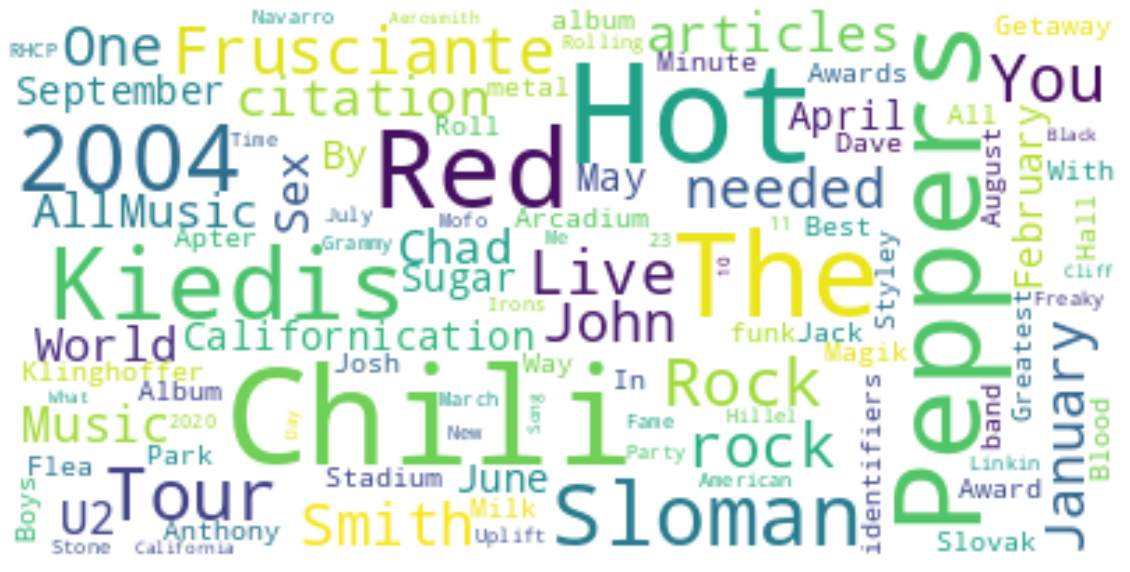

In [103]:
# Now i will show it nicely haha

d = pd.Series(df.score.values,index=df.word).to_dict()

wordcloud = WordCloud(background_color = 'white',max_font_size=50, max_words=100)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("img/" + URL.split("/")[-1] + "_firstApproach.png", format="png")
# plt.show()

In [104]:
listOfWords = list(d.keys())[0:50]

In [105]:
countsPerWordOnCorpus = []

def getCoexistanceOnCorpus(wordA,wordB):
    if wordA == wordB:
        return 1
    count = 0
    for corpus in corpusFromTextFilteredSplitted:
        count += int(wordA in corpus and wordB in corpus)
    return count

for word in listOfWords:
    wordCoex = [word]
    for word2 in listOfWords:
        wordCoex.append(getCoexistanceOnCorpus(word,word2))
    countsPerWordOnCorpus.append(wordCoex)


In [106]:
columns = ['word']
columns.extend(listOfWords)
print(columns)
df = pandas.DataFrame(countsPerWordOnCorpus,columns=columns)
df = df.set_index('word')
df.head()

['word', 'Hot', 'Chili', 'Peppers', 'The', 'Red', 'Kiedis', '2004', 'Sloman', 'Tour', 'Rock', 'Frusciante', 'You', 'rock', 'Live', 'Smith', 'needed', 'John', 'One', 'January', 'citation', 'articles', 'Music', 'AllMusic', 'Chad', 'U2', 'World', 'Sex', 'September', 'Californication', 'June', 'February', 'Sugar', 'May', 'April', 'By', 'Klinghoffer', 'funk', 'Hall', 'Getaway', 'Flea', 'Award', 'Awards', 'Stadium', 'Way', 'Jack', 'Arcadium', 'Magik', 'Blood', 'Anthony', 'identifiers']


,Hot,Chili,Peppers,The,Red,Kiedis,2004,Sloman,Tour,Rock,...,Award,Awards,Stadium,Way,Jack,Arcadium,Magik,Blood,Anthony,identifiers
word,,,,,,,,,,,,,,,,,,,,,
Hot,1,142,109,19,99,2,0,0,7,2,...,0,0,1,0,0,0,1,1,1,0
Chili,142,1,150,25,94,1,0,0,5,1,...,0,0,1,0,2,0,1,1,1,0
Peppers,109,150,1,19,75,1,0,0,5,2,...,0,0,0,0,2,0,0,0,1,0
The,19,25,19,1,14,1,0,0,7,1,...,0,0,1,2,0,1,0,0,0,0
Red,99,94,75,14,1,0,0,0,6,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
df2 = df

def getScore(row):
    sumRow = np.nansum(row)
    countPositives = (row != 0).sum()
    dividend = countPositives - 1 if countPositives > 1 else 1

    return dividend if dividend == 1 else sumRow/dividend

df2['score'] = df2.apply(lambda row: getScore(row),axis=1)
df2 = df2.sort_values(by=['score'],ascending=False)
df2.head(10)

,Hot,Chili,Peppers,The,Red,Kiedis,2004,Sloman,Tour,Rock,...,Awards,Stadium,Way,Jack,Arcadium,Magik,Blood,Anthony,identifiers,score
word,,,,,,,,,,,,,,,,,,,,,
Red,99,94,75,14,1,0,0,0,6,1,...,0,0,0,0,0,0,0,0,0,23.076923
Peppers,109,150,1,19,75,1,0,0,5,2,...,0,0,0,2,0,0,0,1,0,21.000000
Chili,142,1,150,25,94,1,0,0,5,1,...,0,1,0,2,0,1,1,1,0,20.181818
Hot,1,142,109,19,99,2,0,0,7,2,...,0,1,0,0,0,1,1,1,0,18.863636
Sugar,1,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,21,22,0,0,11.833333
Sex,1,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,21,22,0,0,11.833333
Blood,1,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,21,1,0,0,11.666667
Magik,1,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,1,21,0,0,11.333333
Arcadium,0,0,0,1,0,0,0,0,3,0,...,0,17,0,0,1,0,0,0,0,6.250000


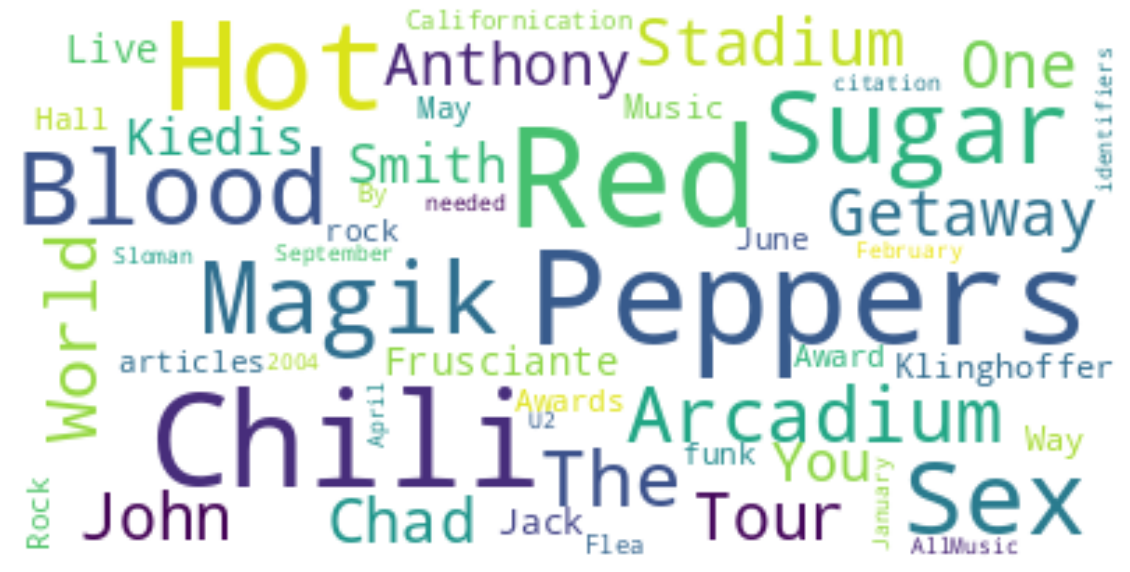

In [108]:

d = pd.Series(df2.score.values,index=df2.index).to_dict()

wordcloud = WordCloud(background_color = 'white',max_font_size=50, max_words=100)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("img/" + URL.split("/")[-1] + "_secondApproach.png", format="png")
# plt.show()

# Approach for bi-grams

In [109]:
vectorizer = CountVectorizer(stop_words='english',lowercase=False,ngram_range=(2,2))
X= vectorizer.fit_transform(phrasesFromText)
featuresNamesBGrams = vectorizer.get_feature_names()

In [110]:
# Filter with words that we extract from the second approach
def areValidWords(wordsngram):
    wordsngramSpplited = wordsngram.split(" ")
    for word in wordsngramSpplited:
        if word not in listOfWords:
            return False
    return True

featuresNamesBGramsfiltered = list(filter(lambda ngram: areValidWords(ngram),featuresNamesBGrams))

In [111]:
BGramScoresMatrix = []

for bgramWord in featuresNamesBGramsfiltered:
    score = [bgramWord]
    bgramWordSplitted = re.split(" ",bgramWord);
    scoreFirstWord = d[bgramWordSplitted[0]]
    scoreSecondWord = d[bgramWordSplitted[1]]
    scoreNgram = scoreFirstWord*scoreSecondWord
    bestScore = max(scoreFirstWord,scoreSecondWord,scoreNgram)
    bestWord = "First Word" if scoreFirstWord == scoreNgram else ("Second Word" if scoreSecondWord == scoreNgram else "Ngram word")
    score.append(scoreFirstWord)
    score.append(scoreSecondWord)
    score.append(scoreNgram)
    score.append(bestScore)
    score.append(bestWord)
    BGramScoresMatrix.append(score)

BGramScoresMatrix

columns = ['word']
columns.extend(['First Word Score','Second Word Score','Ngram Score','Best Score', 'Best Word'])
dfBgram = pd.DataFrame(BGramScoresMatrix,columns=columns)
dfBgram = dfBgram.set_index('word')
dfBgram = dfBgram.sort_values(by=['Best Score'],ascending=False)
dfBgram.head()

,First Word Score,Second Word Score,Ngram Score,Best Score,Best Word
word,,,,,
Red Hot,23.076923,18.863636,435.314685,435.314685,Ngram word
Chili Peppers,20.181818,21.000000,423.818182,423.818182,Ngram word
Hot Chili,18.863636,20.181818,380.702479,380.702479,Ngram word
Peppers Blood,21.000000,11.666667,245.000000,245.000000,Ngram word
Sugar Sex,11.833333,11.833333,140.027778,140.027778,Ngram word


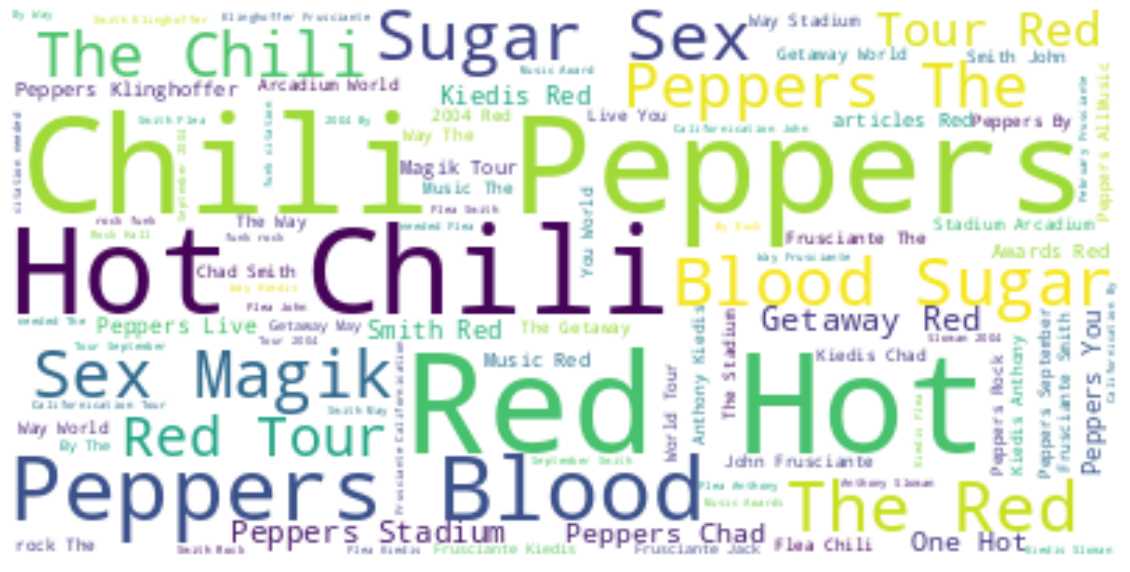

In [112]:
dBGram = pd.Series(dfBgram['Best Score'].values,index=dfBgram.index).to_dict()

wordcloud = WordCloud(background_color = 'white',max_font_size=50, max_words=100)
wordcloud.generate_from_frequencies(frequencies=dBGram)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("img/" + URL.split("/")[-1] + "_BgramApproach.png", format="png")
# plt.show()



# Approach for n-grams

In [113]:
n = 3

vectorizer = CountVectorizer(stop_words='english',lowercase=False,ngram_range=(n,n))
X= vectorizer.fit_transform(phrasesFromText)
featuresNamesNGrams = vectorizer.get_feature_names()

In [114]:
# Filter with words that we extract from the second approach
def areValidWords(wordsngram):
    wordsngramSpplited = wordsngram.split(" ")
    for word in wordsngramSpplited:
        if word not in listOfWords:
            return False
    return True

featuresNamesNGramsfiltered = list(filter(lambda ngram: areValidWords(ngram),featuresNamesNGrams))

In [117]:
NGramScoresMatrix = []
columns = []

def getScoreForNgram(scores):
    result = scores[0]
    for score in scores[1:]:
        result *= score
    return result


for ngramWord in featuresNamesNGramsfiltered:
    scoresForNgram = [ngramWord]
    ngramWordSplitted = re.split(" ",ngramWord);
    for index in range(len(ngramWordSplitted)):
        scoresForNgram.append(d[ngramWordSplitted[index]])
    scoreNgram = getScoreForNgram(scoresForNgram[1:])
    scoresForNgram.append(scoreNgram)
    NGramScoresMatrix.append(scoresForNgram)

BGramScoresMatrix

columnsNgram = ['word']

def getColumnsForNgram(n):
    columnsNames = []
    for index in range(n):
        columnsNames.append(str(index)+ " word Score")
    return columnsNames

columnsNgram.extend(getColumnsForNgram(n))
columnsNgram.extend(["Ngram Score"])
print(columnsNgram)
dfNgram = pd.DataFrame(NGramScoresMatrix,columns=columnsNgram)
dfNgram = dfNgram.set_index('word')
dfNgram = dfNgram.sort_values(by=['Ngram Score'],ascending=False)
dfNgram.head()

['word', '0 word Score', '1 word Score', '2 word Score', 'Ngram Score']


,0 word Score,1 word Score,2 word Score,Ngram Score
word,,,,
Red Hot Chili,23.076923,18.863636,20.181818,8785.441831
Hot Chili Peppers,18.863636,20.181818,21.000000,7994.752066
Chili Peppers Blood,20.181818,21.000000,11.666667,4944.545455
Peppers Blood Sugar,21.000000,11.666667,11.833333,2899.166667
The Red Hot,6.050000,23.076923,18.863636,2633.653846


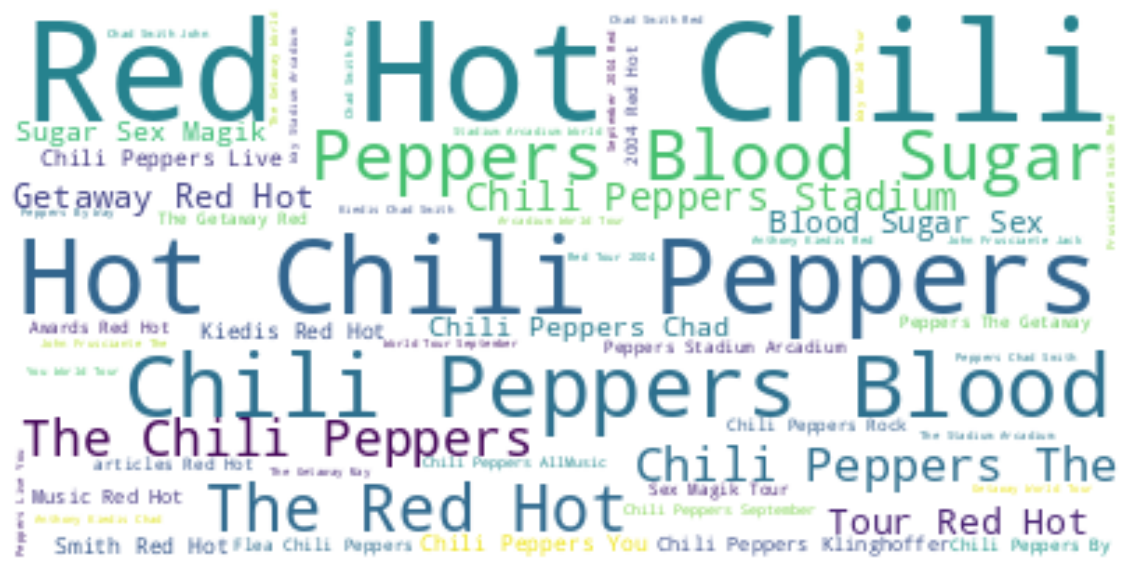

In [118]:
dNgram = pd.Series(dfNgram['Ngram Score'].values,index=dfNgram.index).to_dict()

wordcloud = WordCloud(background_color = 'white',max_font_size=50, max_words=100)
wordcloud.generate_from_frequencies(frequencies=dNgram)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("img/" + URL.split("/")[-1] + "_NgramApproach.png", format="png")
# plt.show()